# Captain Cook: the fabulous recipes explorator



Objectives:

- Create our own JSON map to plot informations about the recipes by region more specifically
- Make the map more interactive and correct the colormap issue
- Finish the ingredients list cleaning
- Use statistical properties of the English language or Levenshtein distance
- Create a user friendly recipe finder 


Bonus:

- Try to compute missing nutritional informations
- Find meaningful substitutions for ingredients

In [1]:
# Basic imports
import re
import os.path
import numpy as np
import scipy as sp
import pandas as pd

# Map-related imports
import json
import branca
import folium
from pandas.io.json import json_normalize
from IPython.core.display import display, HTML

# Plot-related imports
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual

In [2]:
# General parameters
%matplotlib inline
plt.style.use('seaborn')#switch to seaborn style
plt.rcParams["figure.figsize"] = [16,10]

DATA_FOLDER = './data/'

# 1. Data Loading
  
The Data has been fetched and cleaned with `BASH`scripts, please look in the *dataCleaning* section to understand how this was achieved.  

**Home made fetched dataset:**

In [3]:
# Importing ingredients to Pandas DF
allrecipes_df = pd.read_csv(DATA_FOLDER + 'allrecipes.csv', sep='\t',  header=None, encoding = "utf-8")
allrecipes_df.columns = ['ID', 'Region', 'Title', 'Ingredients', 'kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol']

# Bug?? need to convert into numeric somes, TODO EFFICIENT WAY TO DO THIS???
allrecipes_df['kcal'] = pd.to_numeric(allrecipes_df['kcal'], errors='coerce')
allrecipes_df['carb'] = pd.to_numeric(allrecipes_df['carb'], errors='coerce') / 1000.0 # convert to g
allrecipes_df['fat'] = pd.to_numeric(allrecipes_df['fat'], errors='coerce') / 1000.0 # convert to g
allrecipes_df['protein'] = pd.to_numeric(allrecipes_df['protein'], errors='coerce')
allrecipes_df['sodium'] = pd.to_numeric(allrecipes_df['sodium'], errors='coerce') / 1000.0
allrecipes_df['cholesterol'] = pd.to_numeric(allrecipes_df['cholesterol'], errors='coerce')

# Remove any rows which isn't properly formatted
allrecipes_df = allrecipes_df.dropna()

# Remove any duplicated lines
allrecipes_df = allrecipes_df.drop_duplicates().set_index('ID')

# Printing
allrecipes_df.head(5)

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,,
b9705d990df6857f20756fc996a54b63,us,Traditional Indiana Persimmon Pudding,2 cups persimmon pulp |2 eggs |1 cup white sug...,278.0,53.9,3.8,7.8,0.224,35.0
4658708d644d7b446d843fed5ddf60c4,us,Fish Tacos,1 cup all-purpose flour |2 tablespoons cornsta...,409.0,43.0,18.8,17.3,0.407,54.0
beed004e2a1772ba0db9da913f54122e,us,Wisconsin Slow Cooker Brats,8 bratwurst |2 (12 fluid ounce) cans or bottle...,377.0,12.8,27.4,13.8,1.046,69.0
96353c72421bd74096277c6cf8b17097,us,Buffalo Chicken Wing Sauce,2/3 cup hot pepper sauce (such as Frank&#39;s ...,104.0,0.4,11.6,0.2,0.576,31.0
ee659a6a5e69834b60744cc3e103729e,us,Minnesota's Favorite Cookie,"1 cup butter, softened |1 1/2 cups brown sugar...",140.0,14.9,8.7,1.5,0.076,22.0


In [4]:
# Importing descriptions to Pandas DF
allrecipes_desc_df = pd.read_csv(DATA_FOLDER + 'allrecipes_desc.csv', sep='£',  header=None, encoding = "utf-8",  engine='python')
allrecipes_desc_df.columns = ['ID', 'Description']

# Remove any duplicated lines
allrecipes_desc_df = allrecipes_desc_df.drop_duplicates().set_index('ID')

allrecipes_desc_df.head(5)

,Description
ID,
b9705d990df6857f20756fc996a54b63,Preheat the oven to 350 degrees F (175 degree...
4658708d644d7b446d843fed5ddf60c4,"To make beer batter: In a large bowl, combine..."
beed004e2a1772ba0db9da913f54122e,"Place bratwurst, beer, onion, and ketchup in ..."
96353c72421bd74096277c6cf8b17097,"Combine the hot sauce, butter, vinegar, Worce..."
ee659a6a5e69834b60744cc3e103729e,Preheat oven to 350 degrees F (175 degrees C)...


In [5]:
print("Number of recipes:", len(allrecipes_df.index.unique()))

Number of recipes: 15894


**Provided Dataset**

This dataset was provided with the assignment and cleaned with the provided `Perl` scripts. 

Thanks to the scripts, we obtain two datasets:

1. `cleaned_ing.csv` contains the list of ingredients for each recipe,
2. `cleaned_nutri.csv` contains the corresponding nutritional values.

Our objective is to merge these two sets to obtain a unique set with all useful informations.

In [6]:
# Importing ingredients to Pandas DF
ing_df = pd.read_csv(DATA_FOLDER + 'cleaned_ing.csv', sep='\t',  header=None, encoding = "utf-8")
ing_df.columns = ['ID', 'Title', 'Ingredients']

# Importing nutritional values to Pandas DF
nutri_df = pd.read_csv(DATA_FOLDER + 'cleaned_nutri.csv', sep='\t',  header=None, encoding = "utf-8")
nutri_df.columns = ['ID', 'kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol']

# Merging
ing_df = ing_df.set_index('ID')
nutri_df = nutri_df.set_index('ID')
provided_df = ing_df.merge(nutri_df, on='ID', how='inner')

# Drop NaNs and duplicate lines
provided_df = provided_df.dropna().drop_duplicates()

provided_df.head()

,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,
38e1b80017526d6e59ed3f986c35a43a,T.G.I. Friday's Jack Daniels Sauce Recipe #10265,1 teaspoon onion powder|1 tablespoon Tabasco s...,?,?,?,?,?,?
a3636a4dab434fe21fbcdceba7d6fcf2,Simple Peanut Squash Recipe,1 butternut squash|2 tablespoons brown sugar|1...,536,86.4,23.6,6.5,483,61
117f3c214e9de550a157ce5ee1f1cceb,Hash Brown Breakfast Casserole Recipe,"1 lb ground sausage (""hot"" or ""sage"" flavored)...",660.4,24.7,47.3,32.5,1248.0,251.6
fde8f280a690fb8bc77c10a7193db08b,Basic Homemade Country Sausage Recipe,2 pounds lean pork|1/2 pound pork fatback|3 te...,?,?,?,?,?,?
714df642f50b9ae489d285e16b59bf7b,Spinach Frittata Recipe,1 cup fresh spinach|2 egg whites|1 egg yolk|1/...,?,?,?,?,?,?


We can observe that some nutritional values are missing, which can be solved either by removing the lines or by trying to calculate these values from the given ingredients.

As trying to calculate the values from ingredients with different units (i.e. grams, cups, tbsp, etc) requires a set of informations that we do not have, we decided to leave these lines as they are for now. 

In [7]:
# Bug?? need to convert into numeric somes, TODO EFFICIENT WAY TO DO THIS???
provided_df['kcal'] = pd.to_numeric(provided_df['kcal'], errors='coerce')
provided_df['carb'] = pd.to_numeric(provided_df['carb'], errors='coerce')
provided_df['fat'] = pd.to_numeric(provided_df['fat'], errors='coerce')
provided_df['protein'] = pd.to_numeric(provided_df['protein'], errors='coerce')
provided_df['sodium'] = pd.to_numeric(provided_df['sodium'], errors='coerce')
provided_df['cholesterol'] = pd.to_numeric(provided_df['cholesterol'], errors='coerce')

# Insert Region column to match the other DF
provided_df.insert(loc=1, column='Region', value=np.nan)
provided_df.head(5)

,Title,Region,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,,
38e1b80017526d6e59ed3f986c35a43a,T.G.I. Friday's Jack Daniels Sauce Recipe #10265,NaN,1 teaspoon onion powder|1 tablespoon Tabasco s...,NaN,NaN,NaN,NaN,NaN,NaN
a3636a4dab434fe21fbcdceba7d6fcf2,Simple Peanut Squash Recipe,NaN,1 butternut squash|2 tablespoons brown sugar|1...,536.0,86.4,23.6,6.5,483.0,61.0
117f3c214e9de550a157ce5ee1f1cceb,Hash Brown Breakfast Casserole Recipe,NaN,"1 lb ground sausage (""hot"" or ""sage"" flavored)...",660.4,24.7,47.3,32.5,1248.0,251.6
fde8f280a690fb8bc77c10a7193db08b,Basic Homemade Country Sausage Recipe,NaN,2 pounds lean pork|1/2 pound pork fatback|3 te...,NaN,NaN,NaN,NaN,NaN,NaN
714df642f50b9ae489d285e16b59bf7b,Spinach Frittata Recipe,NaN,1 cup fresh spinach|2 egg whites|1 egg yolk|1/...,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print("Number of recipes:", len(provided_df.index.unique()))

Number of recipes: 31376


In [9]:
# Concatenate the 2 DF and drop any duplicated lines, it is possible since some data come from the same website!
recipes_df = allrecipes_df.append(provided_df, sort=False).drop_duplicates()
recipes_df['Region'] = recipes_df['Region'].astype('category')

recipes_df.head()

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,,
b9705d990df6857f20756fc996a54b63,us,Traditional Indiana Persimmon Pudding,2 cups persimmon pulp |2 eggs |1 cup white sug...,278.0,53.9,3.8,7.8,0.224,35.0
4658708d644d7b446d843fed5ddf60c4,us,Fish Tacos,1 cup all-purpose flour |2 tablespoons cornsta...,409.0,43.0,18.8,17.3,0.407,54.0
beed004e2a1772ba0db9da913f54122e,us,Wisconsin Slow Cooker Brats,8 bratwurst |2 (12 fluid ounce) cans or bottle...,377.0,12.8,27.4,13.8,1.046,69.0
96353c72421bd74096277c6cf8b17097,us,Buffalo Chicken Wing Sauce,2/3 cup hot pepper sauce (such as Frank&#39;s ...,104.0,0.4,11.6,0.2,0.576,31.0
ee659a6a5e69834b60744cc3e103729e,us,Minnesota's Favorite Cookie,"1 cup butter, softened |1 1/2 cups brown sugar...",140.0,14.9,8.7,1.5,0.076,22.0


In [10]:
print("Number of total recipes:", len(recipes_df.index.unique()))

Number of total recipes: 46999


In [11]:
len(recipes_df[recipes_df['Region']=='italian'])/365

6.841095890410959

We see that the total number of recipes is enough to eat italian recipes everyday for almost 7 years!!  
We can save this DataFrame to be use later on.

In [12]:
recipes_df.to_csv(DATA_FOLDER + 'recipes_df.csv', sep='\t', encoding='utf-8')

# 2. Ingredient parsing
The cleaning is presented in `DataCleaning.ipynb`, here we use directly the result which is a list of good ingredient that can be matched in the recipes and are relevant for any statistical analysis

In [30]:
# Load csv file 'hand' cleaned
with open(DATA_FOLDER + 'cleaned_list') as f:
    ing_list = f.read().splitlines()
    
# Load the dictionnary that correct the name mispelled
ing_dict = np.load(DATA_FOLDER + 'ing_dict.npy').item()

# Test, if it doesn't exist then it stops the program
ing_dict['onionns']

KeyError: 'onionns'

In [ ]:
# Test to Analyze the occurences
# lowercase to be insensitive
recipes_copy = recipes_df.copy()
recipes_copy['Ingredients'] = recipes_copy['Ingredients'].str.lower()

# Remove non alphabetic values expect of '|' which is the seperating char
recipes_copy['Ingredients'] = recipes_copy['Ingredients'].str.replace('[^a-zA-Z ]+', ' ')

# Retrieve list of ingredients in overall
ing_ds = recipes_copy['Ingredients'].str.split(" ", expand=True) \
                                    .stack() \
                                    .map(ing_dict) \
                                    .value_counts()  \
                                    .to_frame()  \
                                    .reset_index()

# When we do .map(ind_dict) it will try to apply the dict to each element of the expanded stacked DF
# if it doesnt exist then it replace it by '', otherwise it applies the dictionnary (e.g onions -> onion)

# Renaming for ease of indexing
ing_ds.columns = ['name','count'] 

# Keeping only the ingredient in the previous list
ing_ds

In [36]:
ing_ds = recipes_copy['Ingredients'].str.split(" ", expand=True) \
                                    .stack() \
                                    .map(ing_dict).dropna()
ing_ds

ID                                   
b9705d990df6857f20756fc996a54b63  3           persimmon
                                  7                eggs
                                  18              flour
                                  27               milk
                                  31             butter
4658708d644d7b446d843fed5ddf60c4  5               flour
                                  9          cornstarch
                                  14             powder
                                  18               salt
                                  25               beef
                                  30             yogurt
                                  34         mayonnaise
                                  37               lime
                                  43             pepper
                                  50             capers
                                  60              cumin
                                  65               dill
          

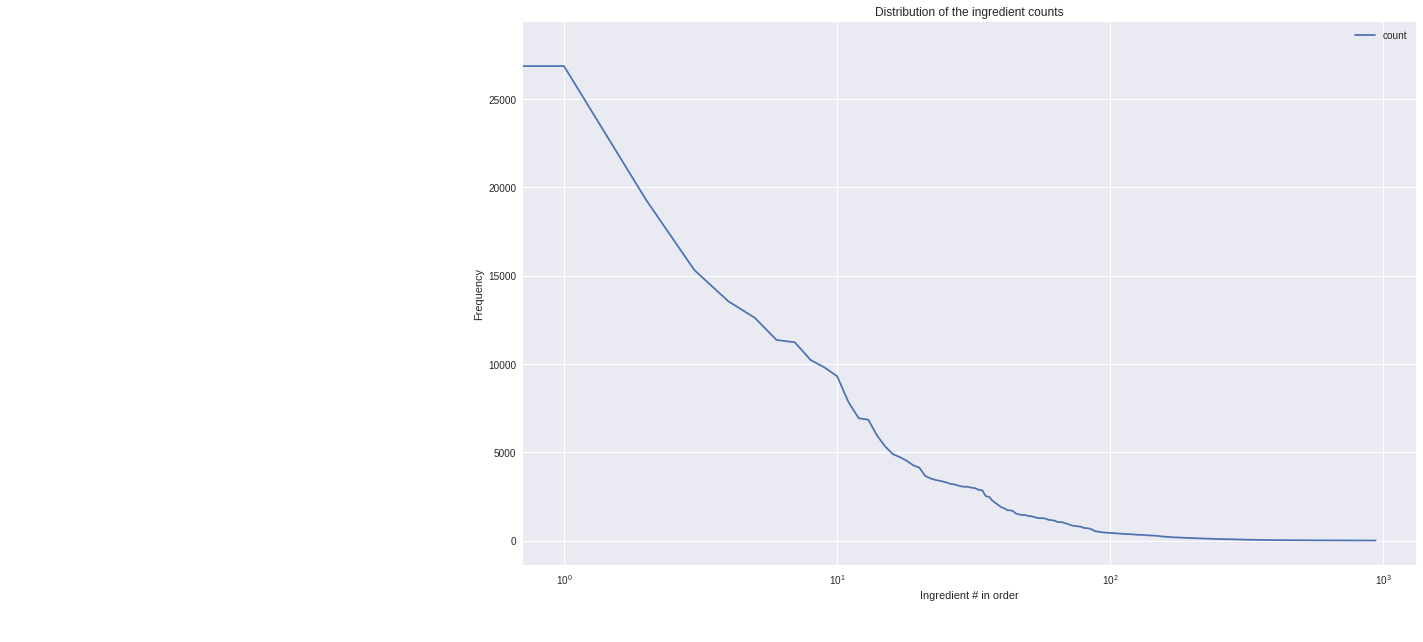

In [15]:
# TODO THIS SHOULD BE MOVE BELOW, IT IS AN ANALYSIS -> Quite useless but hey :P
ing_ds.plot()

plt.xscale("log")
plt.xlabel('Ingredient # in order')
plt.ylabel('Frequency')
plt.title('Distribution of the ingredient counts')
plt.show()

# 3. Cooking time study-case

In this part we would like to analyze the cooking time of the recipes to be able to classify which regions have the highest and lowest cooking time.

In [16]:
# Extract all timing from recipes
timing_df = allrecipes_desc_df['Description'].str.extractall(r'(\d+) minutes|(\d+) hour|hours')
timing_df.columns = ['minutes', 'hours']

#Replace Nan by 0 and switch to int type
timing_df = timing_df.fillna(0).astype(int)

#Sum the number of minutes to get the recipe time
timing_df['Time (min)'] = timing_df['minutes']+timing_df['hours']*60

timing_df.head()

minutes  hours  Time (min)
ID                               match                            
b9705d990df6857f20756fc996a54b63 0            0      2         120
                                 1           15      0          15
beed004e2a1772ba0db9da913f54122e 0            0      4         240
                                 1            5      0           5
ee659a6a5e69834b60744cc3e103729e 0           12      0          12

In [17]:
# Sum the total amount of time for each recipe
time_recipe = timing_df.groupby('ID').agg('sum')
time_recipe = time_recipe.drop(['minutes','hours'], axis=1)

time_recipe.head()

,Time (min)
ID,
00035a69b44a9dd1f88f2bb5faced261,90
000d31e632cab9e6902f05196354a007,660
0015417d2473d92a56da28883a27aff3,120
001cf1a5a0d1914f958cb2c823df6121,8
001f5efe07f4c72b4aaf846ec7616aba,13


# 4. Merging
Finally, we can merge everything to a single DataFrame to use it for Visualization

In [18]:
# Merging Cooking Time
cleaned_df = recipes_df.merge(time_recipe, on='ID', how='left')

# Cleaning ingredient and ingredient substition
# This is not yet implemented but we are close to achieve this

cleaned_df.sample(5)

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol,Time (min)
ID,,,,,,,,,,
fd62d4b8a2746d3e75bddd69ac57dcbf,NaN,Creamy Vegan Mashed Potatoes Recipe,8 -10 potatoes (average size)|1/4 cup vegan ma...,128.1,26.6,1.2,3.2,38.800,1.2,NaN
4abd0ba8aa4105ffc9335b0953f30c8d,NaN,Easy Healthy Cottage Cheese Pancakes Recipe,1 cup fat-free cottage cheese|6 egg whites or ...,255.3,31.4,3.0,24.8,404.300,5.0,NaN
b3934920ef1a8bb48cdee6ce363142d3,NaN,Authentic Middle Eastern Hummus (Chummus) Recipe,"3 cups dry garbanzo beans, soaked overnight|1 ...",551.0,51.2,32.3,18.4,127.000,0.0,NaN
a138558a26fab13795e591d2bed0eaad,mexican,Kiwi Fruit Salsa,"1 cup balsamic vinegar |1 Spanish onion, finel...",40.0,9.8,0.2,0.6,0.005,0.0,NaN
b645e533e3d7362cdaa65c978307e682,NaN,Fresh Tomato Sauce Recipe,"4 lbs roma tomatoes, peeled, seeded at chopped...",886.1,89.0,58.2,19.5,2440.600,0.0,NaN


# 5. Analysis

This part presents some basic statistical analysis of the data.

First we analyse the data by region and observe *mean*, *median*, *min* and *max* for each nutritional value.

In [19]:
# Some classic analysis
stats_regions = cleaned_df.groupby('Region')
stats_regions = stats_regions.agg({'kcal' : ['mean', 'median', 'min', 'max'],
                                       'carb' : ['mean', 'median', 'min', 'max'],
                                       'fat' : ['mean', 'median', 'min', 'max'],
                                       'protein' : ['mean', 'median', 'min', 'max'],
                                       'sodium' : ['mean', 'median', 'min', 'max'],
                                       'cholesterol' : ['mean', 'median', 'min', 'max'],
                                       'Time (min)' : ['mean', 'median', 'min', 'max']})
stats_regions.sort_values([('kcal', 'mean')], ascending=False).head()

kcal                            carb                     \
                  mean median   min     max       mean median  min    max   
Region                                                                      
malaysian   435.600000  427.0  33.0  1238.0  30.422857  26.70  1.7  113.2   
portuguese  402.173333  378.0  27.0  2266.0  33.832000  28.50  4.0  108.6   
italian     391.215459  360.0   4.0  1641.0  34.242171  29.90  0.0  174.8   
indonesian  387.648649  401.0  65.0   716.0  29.056757  19.60  6.5   94.2   
french      377.932609  319.5   9.0  3274.0  27.991739  22.05  0.4  240.9   

                  fat          ...   sodium         cholesterol              \
                 mean median   ...      min     max        mean median  min   
Region                         ...                                            
malaysian   24.091429  19.80   ...    0.011   3.031   90.914286   66.0  0.0   
portuguese  20.009333  17.10   ...    0.003  10.693   84.986667   67.0  0.0   
italian     19.998438  17.20   ...    0.001   7.648   71.113736   50.0  0.0   
indonesian  21.545946  19.00   ...    0.004   2.459   97.918919   68.0  0.0   
french      22.572391  18.15   ...    0.002   8.623  100.473913   73.5  0.0   

                   Time (min)                      
              max        mean median  min     max  
Region                                             
malaysian   340.0   88.424242   30.0  2.0  1460.0  
portuguese  389.0  188.071429   50.0  2.0  1533.0  
italian     734.0   89.862860   39.0  0.0  2160.0  
indonesian  500.0   68.972222   28.5  3.0   380.0  
french      780.0  120.860294   45.0  2.0  2880.0  

[5 rows x 28 columns]

# 6. Visualization

In this part we present the overall visualization of informations we retrieve in the dataset.

###  Plots

In [20]:
# Interactive plot of correlation between nutritive values 
def f(nutritive1, nutritive2):
    
    sns.set_context("notebook", font_scale=1.5)
    sns.scatterplot(cleaned_df[nutritive1], cleaned_df[nutritive2])
    plt.show()
    
# Interact
interact(f, nutritive1=['kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol'],
            nutritive2=['kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol']);

interactive(children=(Dropdown(description='nutritive1', options=('kcal', 'carb', 'fat', 'protein', 'sodium', …

In the plot above we can see the correlation between the different nutritional values. 

For example, there are many recipes where high carbs and fats correspond to high caloric plates, but less so for high proteins. Also it would seem that fats and cholesterol are not as correlated as we would think.

Below is a plot that shows the correlation coefficient for pairs of nutritional values by region. 

In [21]:
# Correlation between nutritional values shown per region
def f(region):
    sns.set_context("notebook", font_scale=1.5)
    
    # .iloc[:,:-1] is to avoid the Time column
    # It can be interesting to see if there is a correlation
    corr = cleaned_df.iloc[:,:-1][cleaned_df['Region'] == region].corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()
    
# Interact
interact(f, region=cleaned_df.Region.unique().dropna());

interactive(children=(Dropdown(description='region', options=('us', 'korean', 'japanese', 'indonesian', 'thai'…

Below is a plot that shows the statistics by nutritional or time value of recipes classified by region. The plot is automatically ordered by median, so we obtain the region with the highest median for that item value.

In [22]:
# Item value statistics by regions
def f(item):
    recipe_sorted = stats_regions.sort_values([(item, 'median')], ascending=False)

    sns.set_context("notebook", font_scale=1.5)
    sns.boxplot(cleaned_df[item], cleaned_df['Region'], order=recipe_sorted.index)
    
    ## There is a big outlier for Sodium & Time, we will handle it later
    if(item == 'sodium'):
        plt.xlim(-0.5, 10)
        
    if(item == 'Time (min)'):
        plt.xlim(-50, 1500)
    ##
    plt.show()
    
# Interact
interact(f, item=['kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol', 'Time (min)']);

interactive(children=(Dropdown(description='item', options=('kcal', 'carb', 'fat', 'protein', 'sodium', 'chole…

We can see that the most calorical, fat and protein rich recipes belong to Malaysia, while the sodium intake is won by the korean recipes. The ones that have to be most careful about the cholesterol intake seem to be the French.

By comparing the median we also see that the longest cooking time and preparation in total is for Persian recipes, whereas Japanese's recipes are the shortest

### Maps

In [23]:
# Loading JSON of world map
world_json = json.load(open(DATA_FOLDER + 'world-countries.json'))
cont_json = json.load(open(DATA_FOLDER + 'continents.json'))

At the end we will have our own JSON map done with the help of the following website:https://geojson-maps.ash.ms/  
Until then, we show relevant informations for each continent by using a dictionnary that will map `Region` name to its corresponding continent.

In [24]:
#Dic we used to set the continent depending on the region
dic_continent = {'korean': 'Asia','japanese': 'Asia','indonesian': 'Asia', 'thai': 'Asia',
 'indian': 'Asia', 'chinese': 'Asia',
 'bangladeshi': 'Asia','filipino': 'Asia', 'malaysian': 'Asia','pakistani': 'Asia','vietnamese': 'Asia', 'israeli': 'Asia',
 'persian': 'Asia','lebanese': 'Asia','us': 'North America', 'canadian': 'North America',
 'mediteranean': 'Europe', 'turkish': 'Europe', 'dutch': 'Europe', 'italian': 'Europe', 'french': 'Europe',
 'swiss': 'Europe', 'scandinavian': 'Europe','austrian': 'Europe', 'eastern_europe': 'Europe',
 'spanish': 'Europe', 'belgian': 'Europe', 'uk_and_ireland': 'Europe', 'greek': 'Europe',
 'german': 'Europe', 'portuguese': 'Europe', 'african': 'Africa', 'south_american': 'South America',
 'mexican': 'South America', 'australian': 'Australia', 'caribbean':'South America'}

In [25]:
#We create a new column in the df to set the continent depending on the Region
recipes_continent = cleaned_df.copy()
recipes_continent['Continent'] = recipes_continent['Region'].map(dic_continent)
recipes_continent.head(5)

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol,Time (min),Continent
ID,,,,,,,,,,,
b9705d990df6857f20756fc996a54b63,us,Traditional Indiana Persimmon Pudding,2 cups persimmon pulp |2 eggs |1 cup white sug...,278.0,53.9,3.8,7.8,0.224,35.0,135.0,North America
4658708d644d7b446d843fed5ddf60c4,us,Fish Tacos,1 cup all-purpose flour |2 tablespoons cornsta...,409.0,43.0,18.8,17.3,0.407,54.0,NaN,North America
beed004e2a1772ba0db9da913f54122e,us,Wisconsin Slow Cooker Brats,8 bratwurst |2 (12 fluid ounce) cans or bottle...,377.0,12.8,27.4,13.8,1.046,69.0,245.0,North America
96353c72421bd74096277c6cf8b17097,us,Buffalo Chicken Wing Sauce,2/3 cup hot pepper sauce (such as Frank&#39;s ...,104.0,0.4,11.6,0.2,0.576,31.0,NaN,North America
ee659a6a5e69834b60744cc3e103729e,us,Minnesota's Favorite Cookie,"1 cup butter, softened |1 1/2 cups brown sugar...",140.0,14.9,8.7,1.5,0.076,22.0,12.0,North America


In [26]:
def layer_colormap(topojson, df, column, colorscale):
    
    # Create a layer
    feature_map = folium.FeatureGroup(name=column, overlay=False)  
    
    def style_function(feature):
    # Fetching values for the mean of the category for the given asked continent
        value = recipes_continent[recipes_continent['Continent'] == feature['properties']['CONTINENT']][column].mean()
        return {
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.5,
            'fillColor': '#black' if np.isnan(value) else colorscale(value)
                }
    # Fetch values from the DataFrame and apply the colormap to the values
    # If the value is NaN, the corresponding color is dark-grey
    folium.GeoJson(cont_json, style_function=style_function).add_to(feature_map)

    return feature_map;

In [27]:
# Create a new empty map
map_info  = folium.Map([30,0], tiles='cartodbpositron', zoom_start=2)

# Add for each nutritive information the map
for category in ['kcal','carb','fat','protein','sodium','cholesterol', 'Time (min)']:
    colorscale = branca.colormap.linear.YlOrRd_09.scale((min(stats_regions[category]['mean'])), max(stats_regions[category]['mean']))
    layer_colormap(cont_json, recipes_continent, category, colorscale).add_to(map_info)
    
# Add a legend to the colormap and append it to the base layer
colorscale.caption = 'Mean of the nutritive value selected'
map_info.add_child(colorscale) 

# Adding the tile Layer thus it is prettier
folium.TileLayer(tiles='cartodbpositron', overlay=True).add_to(map_info)

# Layer Control to select the different layer created before
folium.LayerControl(collapsed=False, position='bottomleft').add_to(map_info);

# Save/Display
map_info.save('map_info.html')
#map_info

In [28]:
%%HTML
<iframe src="map_info.html" width=100% height=700></iframe>

On the previous map, we can see how the different nutritive properties of the recipes vary through the different continents. We can thus see some correlations like the kcal of the recipe and the fat which are both high in the same continents.  

**Note:** we actually have a small issue with the colormap and we will be fixing it by using a different kind of interactive map to show more interesting information (Ingredients distribution, min/max or median for nutrition)